In [35]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, f1_score, confusion_matrix
from sklearn.utils import class_weight
from scipy.signal import butter, filtfilt

In [36]:
# TensorFlow 버전 확인
print(f"TensorFlow version: {tf.__version__}")

# GPU 설정
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            try:
                # 최신 API 사용
                tf.config.set_memory_growth(gpu, True)
                print(f"Set memory growth for GPU: {gpu}")
            except AttributeError:
                # 이전 API 사용
                tf.config.experimental.set_memory_growth(gpu, True)
                print(f"Set memory growth for GPU using experimental API: {gpu}")
    except RuntimeError as e:
        print(f"Failed to set memory growth: {e}")
else:
    print("No GPU devices found. Running on CPU.")

TensorFlow version: 2.16.1
Set memory growth for GPU using experimental API: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [37]:
# Step 1: 데이터 로드 함수 (세션 정보 제거)
def load_eeg_data(directory):
    """
    지정된 디렉토리에서 EEG 데이터를 로드하고, 피험자별로 그룹화합니다.

    Parameters:
        directory (str): .npy 파일이 있는 디렉토리 경로.

    Returns:
        data_dict (dict): 피험자 ID를 키로 하고, 해당 피험자의 데이터와 라벨을 값으로 하는 딕셔너리.
    """
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npy')]
    if not files:
        raise FileNotFoundError("No .npy files found in the directory.")

    data_dict = {}
    for file in files:
        # Extract participant ID and label from filename
        basename = os.path.basename(file)
        parts = basename.split('_')
        if len(parts) < 3:
            raise ValueError(f"Unexpected file naming format: {basename}")

        participant_id = parts[0]
        label_str = parts[1]
        # 'FB'는 세션 식별자가 아니므로 무시

        if 'positive' in label_str.lower():
            label = 1
        elif 'negative' in label_str.lower():
            label = 0
        else:
            raise ValueError(f"File name does not indicate label: {file}")

        raw_data = np.load(file)

        # Check if raw_data has the expected shape (samples, channels, timesteps)
        if len(raw_data.shape) != 3:
            raise ValueError(f"Unexpected data shape {raw_data.shape} in file: {file}")

        # Initialize dictionary for participant if not exists
        if participant_id not in data_dict:
            data_dict[participant_id] = {'data': [], 'labels': []}

        # Append raw data and labels
        data_dict[participant_id]['data'].append(raw_data)
        data_dict[participant_id]['labels'].extend([label] * raw_data.shape[0])

    # Concatenate data for each participant
    for participant in data_dict:
        data_dict[participant]['data'] = np.concatenate(data_dict[participant]['data'])
        data_dict[participant]['labels'] = np.array(data_dict[participant]['labels'])

    return data_dict


In [38]:
# Step 2: 밴드패스 필터링 함수
def bandpass_filter(data, lowcut=4, highcut=45, fs=128, order=5):
    """
    EEG 데이터에 밴드패스 필터를 적용합니다.

    Parameters:
        data (np.ndarray): EEG 데이터.
        lowcut (float): 저주파 컷오프 주파수.
        highcut (float): 고주파 컷오프 주파수.
        fs (float): 샘플링 주파수.
        order (int): 필터 차수.

    Returns:
        filtered_data (np.ndarray): 필터링된 EEG 데이터.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=-1)

In [39]:
# Step 3: 데이터 정규화 함수
def normalize_eeg_data(data):
    """
    EEG 데이터를 정규화합니다.

    Parameters:
        data (np.ndarray): EEG 데이터.

    Returns:
        normalized_data (np.ndarray): 정규화된 EEG 데이터.
    """
    return (data - np.mean(data, axis=-1, keepdims=True)) / np.std(data, axis=-1, keepdims=True)


In [40]:
# Step 4: 데이터 증강 함수
def augment_eeg_data(X, y):
    # Gaussian 노이즈 추가
    noise = np.random.normal(0, 0.01, X.shape)
    X_noise = X + noise

    # 시간 이동 (shift)
    shift = np.roll(X, shift=10, axis=1)  # timesteps 축을 기준으로 10 타임스텝 이동
    X_shift = shift

    # 윈도우 슬라이싱 (윈도우 크기 80%로 자르기)
    X_sliced = X[:, :int(X.shape[1] * 0.8), :]

    # 증강된 데이터와 라벨 결합
    X_augmented = np.concatenate([X, X_noise, X_shift, X_sliced], axis=0)
    y_augmented = np.concatenate([y, y, y, y], axis=0)
    
    return X_augmented, y_augmented

In [41]:
# Step 5: 클래스 불균형 처리 함수 (SMOTE)
def balance_classes(X, y):
    smote = SMOTE(random_state=42)
    X_reshaped = X.reshape(X.shape[0], -1)
    X_balanced, y_balanced = smote.fit_resample(X_reshaped, y)
    X_balanced = X_balanced.reshape(-1, X.shape[1], X.shape[2])
    return X_balanced, y_balanced

In [42]:
# Step 4: CNN 모델 정의 (수정)
def create_cnn_model(input_shape, num_classes):
    """
    CNN 모델을 생성합니다.

    Parameters:
        input_shape (tuple): 입력 데이터 형상 (timesteps, channels).
        num_classes (int): 분류할 클래스 수.

    Returns:
        model (tf.keras.Model): 컴파일된 CNN 모델.
    """
    model = Sequential([
        Input(shape=input_shape),
        
        # Conv1D + BatchNormalization + Dropout
        Conv1D(16, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2, strides=2, padding='same'),
        Dropout(0.3),  # 드롭아웃 비율을 0.3로 변경

        Conv1D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2, strides=2, padding='same'),
        Dropout(0.3),  # 드롭아웃 비율을 0.3로 변경

        # Fully Connected Layer
        Flatten(),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),  # Fully Connected Layer에서도 드롭아웃 비율 증가
        Dense(num_classes, activation='softmax')
    ])
    
    # 모델 컴파일
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [43]:
# Step 5: 데이터 전처리 함수 (세션 정보 제거)
def preprocess_eeg_data(directory):
    """
    Preprocess EEG data: bandpass filter and normalize.

    Parameters:
        directory (str): Path to the directory containing .npy files.

    Returns:
        preprocessed_dict (dict): Dictionary with preprocessed data and labels per participant.
    """
    # 데이터 로드
    data_dict = load_eeg_data(directory)
    print("데이터 로드 완료.")

    # 전처리된 데이터를 저장할 딕셔너리 초기화
    preprocessed_dict = {}
    
    for participant, content in data_dict.items():
        X = content['data']
        y = content['labels']
        
        # 밴드패스 필터링
        X = bandpass_filter(X)

        # 데이터 정규화
        X = normalize_eeg_data(X)

        # 데이터 축 재정렬: (samples, channels, timesteps) -> (samples, timesteps, channels)
        X = np.transpose(X, (0, 2, 1))

        # 전처리된 데이터 저장
        preprocessed_dict[participant] = {'data': X, 'labels': y}
        print(f"Participant {participant} 전처리 완료.")

    return preprocessed_dict

In [44]:
# Step 6: Intra-Session (Intra-Subject) 교차 검증 및 모델 학습
def train_model_intra_subject_split(preprocessed_dict, model_path, test_size=0.2, random_state=42):
    """
    Intra-Session 교차 검증을 사용하여 CNN 모델을 학습합니다.
    각 피험자별로 훈련 세트와 테스트 세트를 분리하여 모델을 학습하고 평가합니다.

    Parameters:
        preprocessed_dict (dict): 전처리된 피험자별 데이터와 라벨.
        model_path (str): 학습된 모델을 저장할 경로.
        test_size (float): 테스트 세트의 비율 (예: 0.3 for 30%).
        random_state (int): 랜덤 시드.
    """
    # 결과 파일 초기화
    result_filename = "bio_cnn_eeg_results_raw_intra.txt"
    with open(result_filename, "w") as result_file:
        result_file.write("Intra-Session(Subject) Cross-Validation Results\n")
    
    # Initialize lists to collect metrics
    all_accuracy = []
    all_roc_auc = []
    all_f1 = []
    all_cm = []
    prediction_details = []

    # Iterate over each participant
    for participant, content in preprocessed_dict.items():
        X = content['data']
        y = content['labels']
        num_classes = len(np.unique(y))
        print(f"\nParticipant: {participant}, Samples: {X.shape[0]}, Classes: {num_classes}")

        # Initialize StratifiedShuffleSplit
        sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)

        for train_index, test_index in sss.split(X, y):
            print(f"  Splitting data: Train size = {len(train_index)}, Test size = {len(test_index)}")

            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            y_train_cat = to_categorical(y_train, num_classes)
            y_test_cat = to_categorical(y_test, num_classes)

            # Compute class weights
            class_weights_vals = class_weight.compute_class_weight(
                class_weight='balanced',
                classes=np.unique(y_train),
                y=y_train
            )
            class_weights_dict = dict(enumerate(class_weights_vals))
            print(f"    Class weights: {class_weights_dict}")

            # Create a new model instance
            model = create_cnn_model(input_shape=X_train.shape[1:], num_classes=num_classes)

            # Define callbacks
            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=5, restore_best_weights=True
            )

            # ModelCheckpoint 수정: .h5 형식으로 저장, save_weights_only=True 추가
            checkpoint = tf.keras.callbacks.ModelCheckpoint(
                filepath=f"{model_path}_participant_{participant}.weights.h5",  # 수정: .weights.h5로 저장
                monitor='val_loss',
                save_best_only=True,
                verbose=1,
                save_weights_only=True  # 가중치만 저장
            )

            # Train the model
            history = model.fit(
                X_train,
                y_train_cat,
                epochs=100,
                batch_size=16,
                verbose=1,  # Set to 1 for more detailed logs
                validation_split=0.2,
                callbacks=[early_stopping, checkpoint],
                class_weight=class_weights_dict
            )

            # Load the best model
            model.load_weights(f"{model_path}_participant_{participant}.weights.h5")
            model.save(f"{model_path}_participant_{participant}.h5")  # 전체 모델을 .h5로 저장
            
            # Evaluate the model
            predictions = model.predict(X_test)
            test_accuracy = model.evaluate(X_test, y_test_cat, verbose=0)[1]
            all_accuracy.append(test_accuracy)

            # Calculate ROC AUC
            if num_classes == 2:
                roc_auc = roc_auc_score(y_test, predictions[:,1])
            else:
                roc_auc = roc_auc_score(y_test_cat, predictions, multi_class='ovr')
            all_roc_auc.append(roc_auc)

            # Calculate F1 score
            y_pred_labels = np.argmax(predictions, axis=1)
            f1 = f1_score(y_test, y_pred_labels, average='weighted')
            all_f1.append(f1)

            # Calculate Confusion Matrix
            cm = confusion_matrix(y_test, y_pred_labels)
            all_cm.append(cm)

            # Calculate FPR and TPR for binary classification
            if num_classes == 2:
                if cm.shape == (2, 2):
                    TN, FP, FN, TP = cm.ravel()
                    fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
                    tpr = TP / (TP + FN) if (TP + FN) > 0 else 0
                else:
                    # Handle cases where one class might be missing in predictions
                    fpr = 'Undefined (One class missing in predictions)'
                    tpr = 'Undefined (One class missing in predictions)'
            else:
                # 다중 클래스의 경우, 평균 FPR, TPR을 계산할 수 없습니다.
                fpr = 'N/A'
                tpr = 'N/A'

            # Generate classification report
            report = classification_report(y_test, y_pred_labels, digits=4)

            # Write to result file
            with open(result_filename, "a") as result_file:
                result_file.write(f"\nParticipant {participant} Classification Report:\n\n")
                result_file.write("Detailed Classification Report:\n")
                result_file.write(report)
                result_file.write(f"\nFalse Positive Rate (FPR): {fpr}\n")
                result_file.write(f"True Positive Rate (TPR): {tpr}\n")

            print(f"    Participant {participant} classification report saved.")
            
    # Aggregate Metrics
    avg_accuracy = np.mean(all_accuracy)
    std_accuracy = np.std(all_accuracy)
    avg_roc_auc = np.mean(all_roc_auc)
    std_roc_auc = np.std(all_roc_auc)
    avg_f1 = np.mean(all_f1)
    std_f1 = np.std(all_f1)

    print("\n--- Intra-Session Cross-Validation Results ---")
    print(f"Average Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
    print(f"Average ROC AUC Score: {avg_roc_auc:.4f} ± {std_roc_auc:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f} ± {std_f1:.4f}")

    # Aggregate Confusion Matrices
    total_cm = np.sum(all_cm, axis=0)
    print("\nAggregated Confusion Matrix:")
    print(total_cm)

    # Plot Aggregated Confusion Matrix
    plt.figure(figsize=(6,4))
    plt.imshow(total_cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Aggregated Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(total_cm.shape[0])
    plt.xticks(tick_marks, ['Negative', 'Positive'], rotation=45)
    plt.yticks(tick_marks, ['Negative', 'Positive'])

    # Loop over data dimensions and create text annotations.
    thresh = total_cm.max() / 2.
    for i in range(total_cm.shape[0]):
        for j in range(total_cm.shape[1]):
            plt.text(j, i, format(total_cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if total_cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

    # Save Aggregated Confusion Matrix as Image
    plt.figure(figsize=(6,4))
    plt.imshow(total_cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Aggregated Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(total_cm.shape[0])
    plt.xticks(tick_marks, ['Negative', 'Positive'], rotation=45)
    plt.yticks(tick_marks, ['Negative', 'Positive'])

    # Loop over data dimensions and create text annotations.
    thresh = total_cm.max() / 2.
    for i in range(total_cm.shape[0]):
        for j in range(total_cm.shape[1]):
            plt.text(j, i, format(total_cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if total_cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.savefig("aggregated_confusion_matrix_bio_cnn_raw_intra.png")
    plt.show()

    print(f"Aggregated confusion matrix image saved to 'aggregated_confusion_matrix_bio_cnn_raw_intra.png'")

    # Optionally, append aggregated metrics to the result file
    with open(result_filename, "a") as result_file:
        result_file.write("\n--- Intra-Session Cross-Validation Summary ---\n")
        result_file.write(f"Average Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}\n")
        result_file.write(f"Average ROC AUC Score: {avg_roc_auc:.4f} ± {std_roc_auc:.4f}\n")
        result_file.write(f"Average F1 Score: {avg_f1:.4f} ± {std_f1:.4f}\n")
        result_file.write(f"\nAggregated Confusion Matrix:\n{total_cm}\n")

    print(f"Aggregated results saved to '{result_filename}'")

In [45]:
# Main execution block
def main():
    # 데이터 경로 설정
    data_dir = "/home/bcml1/2025_EMOTION/DEAP_EEG/ch_BPF"  # 실제 데이터가 있는 디렉토리로 업데이트
    model_path = "cnn_model_intra_session"  # 모델 저장 경로 (확장자 제외)

    print("Loading and preprocessing EEG data...")
    preprocessed_dict = preprocess_eeg_data(data_dir)

    print("Starting Intra-Session Cross-Validation...")
    train_model_intra_subject_split(preprocessed_dict, model_path, test_size=0.2, random_state=42)  # 80:20 분할

Loading and preprocessing EEG data...
데이터 로드 완료.
Participant s04 전처리 완료.
Participant s02 전처리 완료.
Participant s29 전처리 완료.
Participant s07 전처리 완료.
Participant s25 전처리 완료.
Participant s01 전처리 완료.
Participant s14 전처리 완료.
Participant s28 전처리 완료.
Participant s19 전처리 완료.
Participant s11 전처리 완료.
Starting Intra-Session Cross-Validation...

Participant: s04, Samples: 33, Classes: 2
  Splitting data: Train size = 26, Test size = 7
    Class weights: {0: 0.7647058823529411, 1: 1.4444444444444444}
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5875 - loss: 1.5896
Epoch 1: val_loss improved from inf to 2.67327, saving model to cnn_model_intra_session_participant_s04.weights.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.5750 - loss: 1.5919 - val_accuracy: 0.6667 - val_loss: 2.6733
Epoch 2/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.1648
Epoch 2: val_loss did not improve from 2.67327
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.165

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
    Participant s04 classification report saved.

Participant: s02, Samples: 32, Classes: 2
  Splitting data: Train size = 25, Test size = 7
    Class weights: {0: 1.1363636363636365, 1: 0.8928571428571429}
Epoch 1/100


/home/bcml1/sigenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bcml1/sigenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bcml1/sigenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5000 - loss: 1.7614
Epoch 1: val_loss improved from inf to 0.70730, saving model to cnn_model_intra_session_participant_s02.weights.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.5000 - loss: 1.7839 - val_accuracy: 0.8000 - val_loss: 0.7073
Epoch 2/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.1661
Epoch 2: val_loss did not improve from 0.70730
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9667 - loss: 0.3747 - val_accuracy: 0.8000 - val_loss: 0.7349
Epoch 3/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.1784
Epoch 3: val_loss did not improve from 0.70730
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 0.1788 - val_accuracy: 0.8000 - val_loss: 0.7841
Epoch 4/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9375 - loss: 0.2780
Epoch 4: val_loss did not improve from 0.70730
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9458 - loss: 0.2656 - val_accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
    Participant s02 classification report saved.

Participant: s29, Samples: 33, Classes: 2
  Splitting data: Train size = 26, Test size = 7
    Class weights: {0: 1.0, 1: 1.0}
Epoch 1/100


/home/bcml1/sigenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bcml1/sigenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bcml1/sigenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6375 - loss: 1.5848
Epoch 1: val_loss improved from inf to 3.68658, saving model to cnn_model_intra_session_participant_s29.weights.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.6417 - loss: 1.5490 - val_accuracy: 0.3333 - val_loss: 3.6866
Epoch 2/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6875 - loss: 1.1648
Epoch 2: val_loss did not improve from 3.68658
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6958 - loss: 1.4780 - val_accuracy: 0.3333 - val_loss: 5.3564
Epoch 3/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.1731
Epoch 3: val_loss did not improve from 3.68658
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 0.1736 - val_accuracy: 0.3333 - val_loss: 6.8207
Epoch 4/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.1816
Epoch 4: val_loss did not improve from 3.68658
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 0.1821 - val_accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
    Participant s29 classification report saved.

Participant: s07, Samples: 31, Classes: 2
  Splitting data: Train size = 24, Test size = 7
    Class weights: {0: 1.5, 1: 0.75}
Epoch 1/100


/home/bcml1/sigenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bcml1/sigenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bcml1/sigenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4868 - loss: 2.3311
Epoch 1: val_loss improved from inf to 0.24595, saving model to cnn_model_intra_session_participant_s07.weights.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.4825 - loss: 2.3067 - val_accuracy: 1.0000 - val_loss: 0.2459
Epoch 2/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.1666
Epoch 2: val_loss improved from 0.24595 to 0.19215, saving model to cnn_model_intra_session_participant_s07.weights.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 1.0000 - loss: 0.1855 - val_accuracy: 1.0000 - val_loss: 0.1921
Epoch 3/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.1740
Epoch 3: val_loss did not improve from 0.19215
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 0.1746 - val_accuracy: 1.0000 - val_loss: 0.1927
Epoch 4/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 0.1829
Epoch 4: val_loss did not improve from 0.19215
2/2 ━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
    Participant s07 classification report saved.

Participant: s25, Samples: 30, Classes: 2
  Splitting data: Train size = 24, Test size = 6
    Class weights: {0: 0.8571428571428571, 1: 1.2}
Epoch 1/100


/home/bcml1/sigenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bcml1/sigenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bcml1/sigenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5707 - loss: 1.4843
Epoch 1: val_loss improved from inf to 3.15608, saving model to cnn_model_intra_session_participant_s25.weights.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.5735 - loss: 1.4794 - val_accuracy: 0.4000 - val_loss: 3.1561
Epoch 2/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8750 - loss: 0.6609
Epoch 2: val_loss did not improve from 3.15608
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8882 - loss: 0.6088 - val_accuracy: 0.4000 - val_loss: 5.7951
Epoch 3/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9375 - loss: 0.2739
Epoch 3: val_loss did not improve from 3.15608
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9441 - loss: 0.2633 - val_accuracy: 0.4000 - val_loss: 7.7695
Epoch 4/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.1771
Epoch 4: val_loss did not improve from 3.15608
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 0.1775 - val_accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
    Participant s25 classification report saved.

Participant: s01, Samples: 39, Classes: 2
  Splitting data: Train size = 31, Test size = 8
    Class weights: {0: 0.9117647058823529, 1: 1.1071428571428572}
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5521 - loss: 2.1295
Epoch 1: val_loss improved from inf to 3.05790, saving model to cnn_model_intra_session_participant_s01.weights.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.5486 - loss: 2.3547 - val_accuracy: 0.4286 - val_loss: 3.0579
Epoch 2/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8750 - loss: 0.9526
Epoch 2: val_loss improved from 3.05790 to 0.98753, saving model to cnn_model_intra_session_participant_s01.weights.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8472 - loss: 1.0226 - val_accuracy: 0.4286 - val_loss: 0.9875
Epoch 3/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.1954
Epoch 3: val_loss improved from 0.98753 to 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
    Participant s01 classification report saved.

Participant: s14, Samples: 31, Classes: 2
  Splitting data: Train size = 24, Test size = 7
    Class weights: {0: 1.0909090909090908, 1: 0.9230769230769231}
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4243 - loss: 2.1256
Epoch 1: val_loss improved from inf to 1.17819, saving model to cnn_model_intra_session_participant_s14.weights.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.4408 - loss: 2.0719 - val_accuracy: 0.4000 - val_loss: 1.1782
Epoch 2/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.1763
Epoch 2: val_loss did not improve from 1.17819
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9649 - loss: 0.2160 - val_accuracy: 0.2000 - val_loss: 1.8212
Epoch 3/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.1767
Epoch 3: val_loss did not improve from 1.17819
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.17

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
    Participant s14 classification report saved.

Participant: s28, Samples: 35, Classes: 2
  Splitting data: Train size = 28, Test size = 7
    Class weights: {0: 1.2727272727272727, 1: 0.8235294117647058}
Epoch 1/100


/home/bcml1/sigenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bcml1/sigenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bcml1/sigenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4460 - loss: 1.8394
Epoch 1: val_loss improved from inf to 0.94567, saving model to cnn_model_intra_session_participant_s28.weights.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.4489 - loss: 1.8598 - val_accuracy: 0.5000 - val_loss: 0.9457
Epoch 2/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9375 - loss: 0.8823
Epoch 2: val_loss did not improve from 0.94567
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9489 - loss: 0.7529 - val_accuracy: 0.3333 - val_loss: 1.0258
Epoch 3/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.1851
Epoch 3: val_loss did not improve from 0.94567
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.1841 - val_accuracy: 0.6667 - val_loss: 1.0331
Epoch 4/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.1841
Epoch 4: val_loss did not improve from 0.94567
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.1849 - val_accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
    Participant s28 classification report saved.

Participant: s19, Samples: 28, Classes: 2
  Splitting data: Train size = 22, Test size = 6
    Class weights: {0: 1.0, 1: 1.0}
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5147 - loss: 1.7059
Epoch 1: val_loss improved from inf to 4.09787, saving model to cnn_model_intra_session_participant_s19.weights.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.5196 - loss: 1.6912 - val_accuracy: 0.2000 - val_loss: 4.0979
Epoch 2/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9375 - loss: 0.3826
Epoch 2: val_loss did not improve from 4.09787
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9400 - loss: 0.3743 - val_accuracy: 0.2000 - val_loss: 4.5756
Epoch 3/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.1759
Epoch 3: val_loss did not improve from 4.09787
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.1761 - val_accuracy: 0.2000 - va

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
    Participant s19 classification report saved.

Participant: s11, Samples: 30, Classes: 2
  Splitting data: Train size = 24, Test size = 6
    Class weights: {0: 0.9230769230769231, 1: 1.0909090909090908}
Epoch 1/100


/home/bcml1/sigenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bcml1/sigenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bcml1/sigenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2878 - loss: 2.4380
Epoch 1: val_loss improved from inf to 7.57458, saving model to cnn_model_intra_session_participant_s11.weights.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.2796 - loss: 2.5898 - val_accuracy: 0.2000 - val_loss: 7.5746
Epoch 2/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9375 - loss: 0.4948
Epoch 2: val_loss did not improve from 7.57458
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9441 - loss: 0.4605 - val_accuracy: 0.2000 - val_loss: 11.5399
Epoch 3/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.1742
Epoch 3: val_loss did not improve from 7.57458
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 0.1746 - val_accuracy: 0.2000 - val_loss: 14.1576
Epoch 4/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.1820
Epoch 4: val_loss did not improve from 7.57458
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 0.1824 - val_ac

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
    Participant s11 classification report saved.

--- Intra-Session Cross-Validation Results ---
Average Accuracy: 0.5488 ± 0.1337
Average ROC AUC Score: 0.4774 ± 0.2128
Average F1 Score: 0.4335 ± 0.1345

Aggregated Confusion Matrix:
[[25  8]
 [23 12]]


/home/bcml1/sigenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bcml1/sigenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bcml1/sigenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


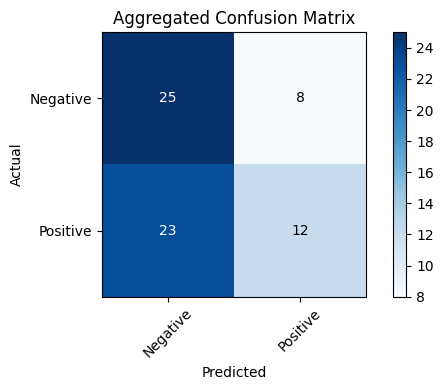

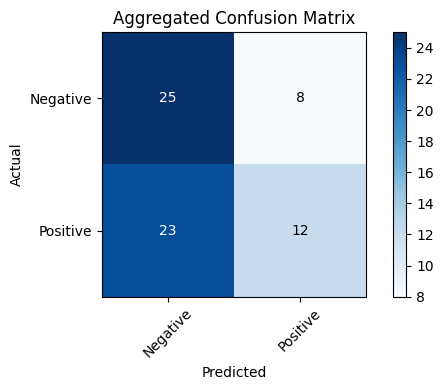

Aggregated confusion matrix image saved to 'aggregated_confusion_matrix_bio_cnn_raw_intra.png'
Aggregated results saved to 'bio_cnn_eeg_results_raw_intra.txt'


In [46]:
if __name__ == "__main__":
    main()